<a href="https://colab.research.google.com/github/NDsasuke/OPTIMIZING-E-COMMERCE-KEYWORD-ANALYSIS-A-STUDY-ON-EFFECTIVE-PRODUCT-TITLE-RECOMMENDATIONS/blob/main/Model3_2_withoutlableencoder_with_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-05-17 10:13:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-17 10:13:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-17 10:13:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

gl

In [ ]:
# load the meta data

import subprocess
import json

# Extract the compressed file using 7zip
subprocess.run(['7z', 'e', '/content/glove.6B.zip'])

CompletedProcess(args=['7z', 'e', '/content/glove.6B.zip'], returncode=2)

In [ ]:
import pandas as pd
import ast
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from itertools import permutations

In [ ]:
# Load the data
df = pd.read_csv('train1.csv')

df = df.drop('target',axis=1)

# Rename the columns properly
df.columns = ['date', 'month', 'year', 'keywords']

# Convert the keywords from strings to lists
df['keywords'] = df['keywords'].apply(ast.literal_eval)

In [ ]:
df.head()

,date,month,year,keywords
0,2014-07-27,7,2014,"[UHU, Contact, Gel, Super, Glue, Adhesive]"
1,2014-07-03,7,2014,"[Steelex, Nylon, Furniture, Caster, Swivel]"
2,2014-07-03,7,2014,"[Steelex, Nylon, Furniture, Caster, Swivel]"
3,2014-07-10,7,2014,"[Zona, Rotating, Bur, Holder, Shank, Burs, Dee..."
4,2014-07-24,7,2014,"[Asphalt, Repair, lb]"


In [ ]:
# Prepare keyword sequences and labels
sequences = []
labels = []
for keywords in df['keywords']:
    for i in range(1, len(keywords)):
        sequences.append(keywords[:i])
        labels.append(keywords[i])

In [ ]:
# All words in sequences and labels
all_words = [word for sublist in sequences + [labels] for word in sublist]

# Count the frequency of each word in the dataset
word_counter = Counter(all_words)

# Set the frequency threshold
freq_threshold = 5

In [ ]:
# Filter out infrequent words
filtered_words = [word for word, count in word_counter.items() if count >= freq_threshold]

# Create word to integer mapping using a dictionary
word_to_int = {word: i for i, word in enumerate(filtered_words)}

# Filter out infrequent words and update sequences and labels
filtered_sequences = []
filtered_labels = []
for sequence, label in zip(sequences, labels):
    filtered_sequence = [word for word in sequence if word in filtered_words]
    if label in filtered_words and len(filtered_sequence) > 0:
        filtered_sequences.append([word_to_int[word] for word in filtered_sequence])
        filtered_labels.append(word_to_int[label])

# Pad sequences
filtered_sequences = pad_sequences(filtered_sequences)


In [ ]:

# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.50d.txt')

embedding_dim = 50  # This should match the dimension of the GloVe embeddings you loaded
embedding_matrix = np.zeros((len(word_to_int), embedding_dim))
for word, i in word_to_int.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras_tuner import RandomSearch, HyperParameters

def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_to_int),
                        output_dim=50,
                        input_length=filtered_sequences.shape[1],
                        weights=[embedding_matrix],
                        trainable=False))

    model.add(LSTM(hp.Int('units', min_value=32, max_value=512, step=32)))

    model.add(Dense(len(word_to_int), activation='softmax'))

    # Use hyperparameters in the optimizer
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='intro_to_kt')

# Perform the hyperparameter search
tuner.search(filtered_sequences,
             np.array(filtered_labels),
             epochs=10,
             validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal number of units in the first densely-connected layer is {best_hps.get('units')} ")
print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)


Epoch 1/10
5730/5730 [==============================] - 51s 8ms/step - loss: 7.6334 - accuracy: 0.0168 - val_loss: 7.6304 - val_accuracy: 0.0154
Epoch 2/10
5730/5730 [==============================] - 43s 7ms/step - loss: 7.3728 - accuracy: 0.0249 - val_loss: 7.6547 - val_accuracy: 0.0192
Epoch 3/10
5730/5730 [==============================] - 43s 7ms/step - loss: 7.2612 - accuracy: 0.0300 - val_loss: 7.6782 - val_accuracy: 0.0196
Epoch 4/10
5730/5730 [==============================] - 48s 8ms/step - loss: 7.1904 - accuracy: 0.0336 - val_loss: 7.6995 - val_accuracy: 0.0204
Epoch 5/10
5730/5730 [==============================] - 48s 8ms/step - loss: 7.1308 - accuracy: 0.0373 - val_loss: 7.7231 - val_accuracy: 0.0205
Epoch 6/10
5730/5730 [==============================] - 48s 8ms/step - loss: 7.0900 - accuracy: 0.0415 - val_loss: 7.7444 - val_accuracy: 0.0211
Epoch 7/10
5730/5730 [==============================] - 43s 7ms/step - loss: 7.0597 - accuracy: 0.0451 - val_loss: 7.7607 - val_ac

In [ ]:
# Train the model
history = model.fit(filtered_sequences, np.array(filtered_labels), epochs=10, validation_split=0.2)


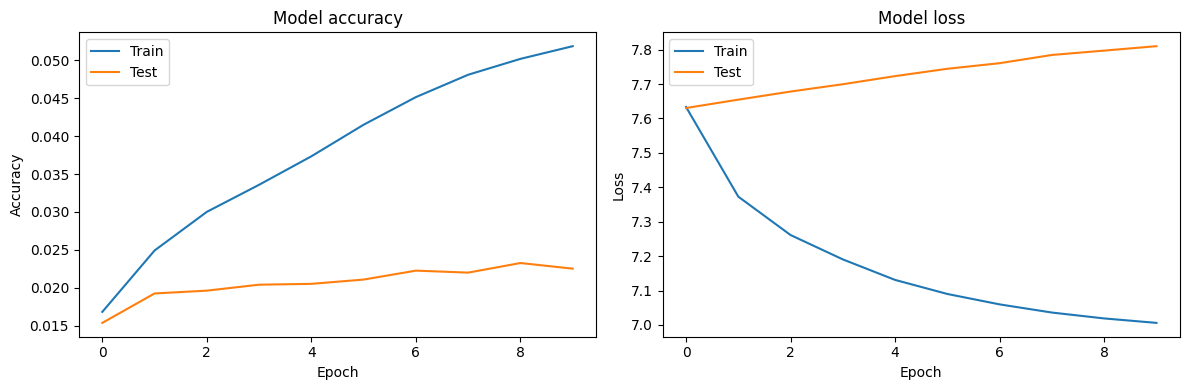

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Define the permutation scoring function
def score_permutation(permutation):
    score = 0
    for i in range(len(permutation) - 1):
        sequence = [word_to_int[permutation[i]]]
        sequence = pad_sequences([sequence], maxlen=filtered_sequences.shape[1])
        prediction = model.predict(sequence)[0]
        next_word_id = word_to_int[permutation[i+1]]
        score += np.log(prediction[next_word_id])
    return score


# Given keywords
keywords = ['IRWIN', 'Unibit', 'Step', 'Drill', 'Bit', 'Set']

# Get all permutations
keyword_perms = list(permutations(keywords))

# Score all permutations
scores = [score_permutation(perm) for perm in keyword_perms]

# Get top 3 permutations
top_indices = np.argsort(scores)[-3:]
top_perms = [keyword_perms[i] for i in top_indices]

print(top_perms)

1/1 [==============================] - 0s 29ms/step
[('Unibit', 'Step', 'Drill', 'Bit', 'IRWIN', 'Set'), ('Unibit', 'IRWIN', 'Step', 'Drill', 'Bit', 'Set'), ('Unibit', 'Drill', 'Step', 'Set', 'IRWIN', 'Bit')]
